**TP : Kernel Approximation**

Author : JOUET Léon 

***Part I : Implementation of Random Fourier features for the gaussian kernel***

In [2]:
import numpy as np # Thinly−wrapped numpy
import pandas as pd
from matplotlib import cm 
import matplotlib as mpl
%matplotlib inline 
from matplotlib import pyplot as plt 

In [3]:
from sklearn.base import BaseEstimator
from sklearn.exceptions import NotFittedError
from scipy.stats import cauchy
from sklearn.metrics.pairwise import rbf_kernel

class RFF(BaseEstimator):
    def __init__(self, gamma = 1, D = 50):
        self.gamma = gamma
        #Dimensionality D (number of MonteCarlo samples)
        self.D = D
        self.fitted = False
        
    def fit(self, X, y=None):
        """ Generates MonteCarlo random samples """
        d = X.shape[1]
        #Generate D iid samples from p(w) 
        self.w = np.sqrt(2*self.gamma)*np.random.normal(size=(self.D,d))
        #Generate D iid samples from Uniform(0,2*pi) 
        self.u = 2*np.pi*np.random.rand(self.D)
        self.fitted = True
        return self
    
    def transform(self,X):
        """ Transforms the data X (n_samples, n_features) to the new map space Z(X) (n_samples, n_components)"""
        if not self.fitted:
            raise NotFittedError("RBF_MonteCarlo must be fitted")
        #Compute feature map Z(x):
        Z = np.sqrt(2/self.D)*np.cos((X.dot(self.w.T) + self.u[np.newaxis,:]))
        return Z
    
    def compute_kernel(self, X):
        """ Computes the approximated kernel matrix K """
        if not self.fitted:
            raise NotFittedError("RBF_MonteCarlo must be fitted")
        Z = self.transform(X)
        K = Z.dot(Z.T)
        return K

In [4]:
#size of data
N_SAMPLES, DIM = 1000, 200 
X = np.random.randn(N_SAMPLES,DIM)

gamma = 2
#Number of monte carlo samples D
Ds = np.arange(1,5000,200)
K_rbf= rbf_kernel(X, gamma=gamma)
errors_RFF_rbf_norm2= []
errors_RFF_rbf_norm1 = []

for D in Ds:
    GAUSS = RFF(gamma=gamma, D=D)
    GAUSS.fit(X)
    K_rbf_a = GAUSS.compute_kernel(X)
    errors_RFF_rbf_norm1.append((np.linalg.norm((K_rbf_a-K_rbf))))
    errors_RFF_rbf_norm2.append(((K_rbf_a-K_rbf)**2).mean())
    

errors_RFF_rbf_norm1 = np.array(errors_RFF_rbf_norm1)
errors_RFF_rbf_norm2 = np.array(errors_RFF_rbf_norm2)

In [5]:
errors_RFF_rbf_norm2.shape

(25,)

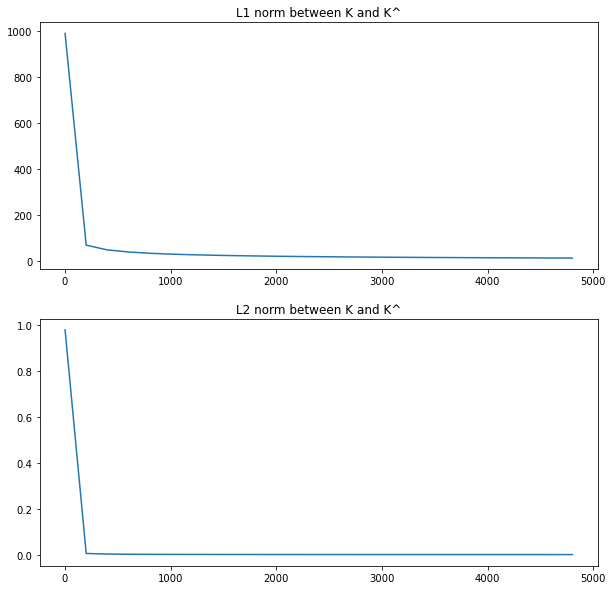

In [6]:
errors = [errors_RFF_rbf_norm1,errors_RFF_rbf_norm2]
name = ["L1 norm between K and K^","L2 norm between K and K^"]
fig = plt.figure(figsize=(10,10))
for i in range(len(errors)) : 
    plt.subplot(2,1,i+1)
    plt.plot(Ds,errors[i])
    plt.title(name[i])
    

On remarque alors que l'erreur d'approximation (L1 et L2) diminue nettement avec le nombre d'échantillons pour approximer la matrice K. Pour trouver le nombre d'échantillon idéal, on peut utiliser la méthode ELBOW. Ainsi, le nombre d'échantillons pour obtenir une bonne approximation semble être autour de 500. 

In [7]:
#Dataset 
from sklearn.model_selection import train_test_split
n_x = 1000 # nombre de points dans le data set
mu = 0
sigma_noise = 1/10
X = np.linspace(0,5,8000)
y = np.array([np.sin(x) + np.sin(3*x+1) + np.random.normal(mu,sigma_noise) for x in X])  
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,shuffle=True)

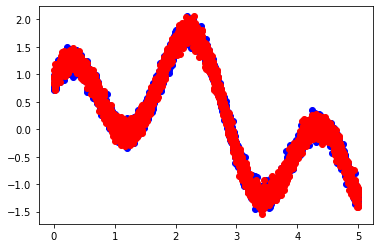

In [8]:
plt.scatter(X_test,y_test,c='blue')
plt.scatter(X_train,y_train,c='red')

In [9]:
X_train = X_train.reshape((-1,1))
y_train = y_train.reshape((-1,1))

X_test = X_test.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [10]:
y_test.shape

(4000, 1)

In [11]:
from sklearn.kernel_ridge import KernelRidge
import time as time
## KKR
gamma = 0.1

KKR = KernelRidge(alpha=1,gamma = gamma, kernel="rbf") #alpha : regularization strength Lambda

start_time = time.time()
KKR.fit(X_train,y_train)
end_time = time.time()

time_KKR = end_time - start_time

err_KKR = ((y_test-KKR.predict(X_test))**2).mean()#erreur entre la prédiction du modèle et les valeurs réelles 

print("KKR MSE :",err_KKR)
print("Training time :",time_KKR)

KKR MSE : 0.37419606965126595
Training time : 1.816821575164795


In [12]:
## KKR RFF
gamma = 0.01
KKR = KernelRidge(alpha=1,gamma = gamma, kernel="precomputed") #alpha : regularization strength Lambda
GAUSS = RFF(gamma=gamma, D=500)
GAUSS.fit(X_train)

X_rbf_estimate_train= GAUSS.compute_kernel(X_train)

start_time = time.time()

KKR.fit(X_rbf_estimate_train,y_train)
end_time = time.time()

time_KKR = end_time - start_time

GAUSS = RFF(gamma=gamma, D=500)
GAUSS.fit(X_test)
X_rbf_estimate_test = GAUSS.compute_kernel(X_test)

err_KKR = ((y_test-KKR.predict(X_rbf_estimate_test))**2).mean()#erreur entre la prédiction du modèle et les valeurs réelles 

print("la MSE de KKR RFF est:",err_KKR)
print("Training time :",time_KKR)

la MSE de KKR RFF est: 16.892418235992764
Training time : 1.2672119140625


**Resultats**

| Method | MSE | Training Time |
| :- | -: | :-: |
| KKR RFF | 16.89 | 1.27s
| KKR  | 0.37 | 1.82s

On remarque alors que le temps d'entraînement est inférieur lorsque l'on utilise l'approximation RFF. Bien entendu, la MSE est plus élevée, cela est dû à l'approximation faite. Lorsque le nombre de données augmente, le différence des temps d'entraînement augmente de plus en plus étant donné la compléxité polynomiale du calcul de K sans approximation

In [14]:
Ds = np.arange(1,5000,200) 

times_kernel_approx = np.zeros(Ds.shape[0])
errors_kernel_approx = np.zeros(Ds.shape[0])

time_kernel_basic = 0
err_kernel_basic = 0

## Kernel method 
start_time2 = time.time()
    
KKR2 = KernelRidge(alpha=1,gamma = gamma, kernel="rbf") #alpha : regularization strength Lambda
KKR2.fit(X_train,y_train)
    
end_time2 = time.time()
    
y_pred_basic = KKR2.predict(X_test)

time_kernel_basic = end_time2 - start_time2
err_kernel_basic = ((y_test-y_pred_basic)**2).mean()

for i,D in enumerate(Ds):
    ## Kernel Approximation method
    start_time1 = time.time()
    
    KKR1 = KernelRidge(alpha=1,gamma = gamma, kernel="precomputed") #alpha : regularization strength Lambda
    GAUSS = RFF(gamma=gamma, D=D)
    GAUSS.fit(X_train)
    K_approx_train = GAUSS.compute_kernel(X_train)
    KKR1.fit(K_approx_train,y_train)
    
    end_time1 = time.time()
    GAUSS.fit(X_test)
    K_approx_test = GAUSS.compute_kernel(X_test)
    y_pred_approx = KKR1.predict(K_approx_test)
    
    ## Time computation
    time_kernel_approx = end_time1 - start_time1
    times_kernel_approx[i] = time_kernel_approx
    
    ## Error computation
    err1 = ((y_test-y_pred_approx)**2).mean()
    errors_kernel_approx[i] = err1


In [15]:
print("MSE for KKR is : ",err_kernel_basic)
print("Time computation for KKR is : ", time_kernel_basic)

MSE for KKR is :  0.49188119036799605
Time computation for KKR is :  0.9005916118621826


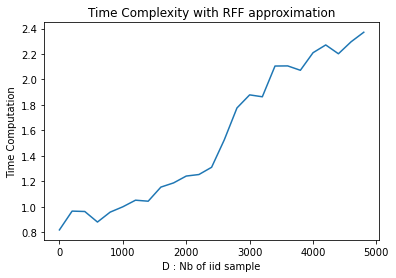

In [20]:
plt.title("Time Complexity with RFF approximation")
plt.xlabel("D : Nb of iid sample")
plt.ylabel("Time Computation")
plt.plot(Ds,times_kernel_approx)


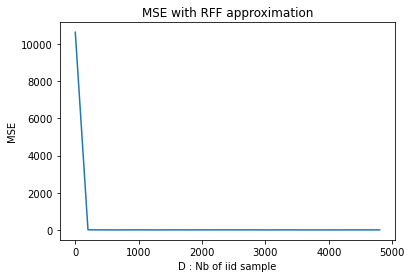

In [21]:
plt.title("MSE with RFF approximation")
plt.xlabel("D : Nb of iid sample")
plt.ylabel("MSE")
plt.plot(Ds,errors_kernel_approx)

**Résultats**
Les résultats sont cohérents. En effet, nous remarquons que la MSE avec la méthode RFF diminue très rapidement avec le nombre d'échantillons de Monte-Carlo. Cependant, un trop grand nombre d'échantillons nous fait perdre l'avntage computationnel de la méthode. Ainsi, nous pouvons conclure que lors d'une regression kernel ridge, si le jeu de données ne dépasse pas quelques milliers d'échantillons, une méthode d'approximation n'est pas nécessaire. En revanche, si le jeu de données comporte plus de 50 000 échantillons, alors une méthode par approximation RFF peut sembler pertinente! 